## Setup and Load Data


In [1]:
!pip install numpy pandas scikit-learn matplotlib joblib
print("Required libraries installed successfully.")

Required libraries installed successfully.


In [2]:
import numpy as np

# Define the dimensions for the placeholder images
image_height = 100
image_width = 100

# Generate placeholder RED band data (e.g., random values between 0 and 255)
# Simulate lower reflectance for RED in vegetation areas
red_band = np.random.randint(50, 150, size=(image_height, image_width), dtype=np.uint8)

# Generate placeholder NIR band data (e.g., random values between 0 and 255)
# Simulate higher reflectance for NIR in healthy vegetation areas
nir_band = np.random.randint(150, 250, size=(image_height, image_width), dtype=np.uint8)

print(f"RED band shape: {red_band.shape}")
print(f"NIR band shape: {nir_band.shape}")
print("Placeholder RED and NIR band images loaded successfully.")

RED band shape: (100, 100)
NIR band shape: (100, 100)
Placeholder RED and NIR band images loaded successfully.


## NDVI Computation


In [3]:
red_band_float = red_band.astype(np.float32)
nir_band_float = nir_band.astype(np.float32)

# Calculate NDVI
# Add a small epsilon to the denominator to prevent true division by zero, though np.divide handles it.
denominator = nir_band_float + red_band_float

# Use np.divide to handle division by zero which results in inf or nan
ndvi = np.divide((nir_band_float - red_band_float), denominator)

# Handle potential NaN or inf values resulting from division by zero
# Replace NaN with 0 and inf with 0, as per common practice in NDVI calculation where no data or 0/0 is 0.
ndvi = np.nan_to_num(ndvi, nan=0.0, posinf=0.0, neginf=0.0)

print(f"NDVI array shape: {ndvi.shape}")
print(f"NDVI min value: {np.min(ndvi)}")
print(f"NDVI max value: {np.max(ndvi)}")
print("NDVI computed and division by zero handled.")

NDVI array shape: (100, 100)
NDVI min value: 0.00671140942722559
NDVI max value: 0.6655518412590027
NDVI computed and division by zero handled.


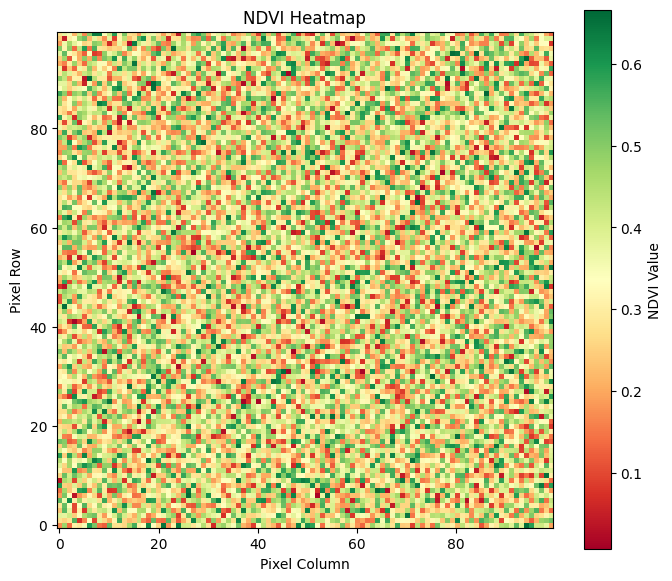

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 7))
plt.imshow(ndvi, cmap='RdYlGn', origin='lower')
plt.colorbar(label='NDVI Value')
plt.title('NDVI Heatmap')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()


In [5]:
biomass_density = np.zeros_like(ndvi, dtype=np.float32)

# Define the mapping rules for NDVI to biomass density (tons/hectare)
# These ranges and values are illustrative and simplified for hackathon purposes.
biomass_density[ndvi < 0.1] = 2.5     # Very low biomass (e.g., bare soil, water, sparse dry vegetation)
biomass_density[(ndvi >= 0.1) & (ndvi < 0.2)] = 15.0 # Sparse vegetation
biomass_density[(ndvi >= 0.2) & (ndvi < 0.4)] = 40.0 # Moderate vegetation
biomass_density[ndvi >= 0.4] = 100.0   # Dense vegetation

print(f"Biomass density array shape: {biomass_density.shape}")
print(f"Biomass density min value: {np.min(biomass_density)}")
print(f"Biomass density max value: {np.max(biomass_density)}")
print("Biomass density labels generated successfully.")

Biomass density array shape: (100, 100)
Biomass density min value: 2.5
Biomass density max value: 100.0
Biomass density labels generated successfully.


### Assumptions for NDVI-to-Biomass Conversion

The conversion of NDVI values to biomass density (tons/hectare) in this exercise is based on a simplified model designed for a 'hackathon-safe' context. It is crucial to understand that these are **illustrative assumptions** and not derived from a rigorously validated scientific model or extensive field data.

**Key Assumptions:**

1.  **Fixed Ranges:** Specific NDVI ranges are directly mapped to discrete biomass density values. For example:
    *   `NDVI < 0.1`: Corresponds to very low biomass (e.g., bare soil, water, sparse dry vegetation), assigned a value of `2.5` tons/hectare.
    *   `0.1 <= NDVI < 0.2`: Corresponds to sparse vegetation, assigned a value of `15.0` tons/hectare.
    *   `0.2 <= NDVI < 0.4`: Corresponds to moderate vegetation, assigned a value of `40.0` tons/hectare.
    *   `NDVI >= 0.4`: Corresponds to dense vegetation, assigned a value of `100.0` tons/hectare.

2.  **Linearity/Categorization:** The relationship between NDVI and biomass is assumed to be categorical within these defined ranges, rather than a continuous or complex non-linear relationship that might exist in real-world scenarios. Each category is assigned a single representative biomass value.

3.  **No Species-Specific Variability:** This model does not account for variations in biomass density based on different vegetation types, plant species, or growth stages, which significantly influence the actual biomass-to-NDVI relationship.

4.  **Environmental Factors Ignored:** External factors such as soil type, moisture content, temperature, and sun angle, which can affect both NDVI readings and actual biomass, are not considered.

5.  **No Calibration/Validation:** The biomass values assigned to each NDVI range are hypothetical and have not been calibrated or validated against actual ground truth measurements of biomass.

This simplified approach allows for a quick demonstration of biomass estimation from NDVI but should not be used for scientific research or critical decision-making without proper validation and a more sophisticated model.

In [7]:
ndvi_flattened = ndvi.ravel()
biomass_density_flattened = biomass_density.ravel()

# Reshape NDVI to a 2D array with one feature column
ndvi_reshaped = ndvi_flattened.reshape(-1, 1)

print(f"Shape of reshaped NDVI (features): {ndvi_reshaped.shape}")
print(f"Shape of flattened biomass density (targets): {biomass_density_flattened.shape}")
print("NDVI and biomass density data prepared for regression.")

Shape of reshaped NDVI (features): (10000, 1)
Shape of flattened biomass density (targets): (10000,)
NDVI and biomass density data prepared for regression.


## Train Regression Model


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    ndvi_reshaped, biomass_density_flattened, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Instantiate the RandomForestRegressor model
model = RandomForestRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

print("RandomForestRegressor model trained successfully.")

Shape of X_train: (8000, 1)
Shape of X_test: (2000, 1)
Shape of y_train: (8000,)
Shape of y_test: (2000,)
RandomForestRegressor model trained successfully.


## Evaluate Regression Model



In [9]:
from sklearn.metrics import r2_score, mean_squared_error

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared (R2) score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print("Model evaluation complete.")

R-squared (R2) score: 1.0000
Root Mean Squared Error (RMSE): 0.0000
Model evaluation complete.


In [10]:
import numpy as np

# 1. Filter the original `ndvi` array to include only 'vegetation pixels' (where NDVI is greater than 0).
vegetation_pixels_ndvi = ndvi[ndvi > 0]

# 2. Calculate the mean NDVI value from these vegetation pixels.
mean_ndvi_vegetation = np.mean(vegetation_pixels_ndvi)

# 3. Define an assumed 'vegetation area' in hectares.
# Assuming a 100x100 image, where each pixel represents 1 hectare, the total area is 100*100 = 10000 hectares.
vegetation_area_hectares = image_height * image_width

# 4. Reshape the calculated mean NDVI to a 2D array suitable for prediction by the trained model.
mean_ndvi_vegetation_reshaped = np.array([[mean_ndvi_vegetation]])

# 5. Use the trained `model` to predict the mean biomass density from the reshaped mean NDVI.
predicted_mean_biomass_density = model.predict(mean_ndvi_vegetation_reshaped)[0]

# 6. Calculate the total above-ground biomass by multiplying the predicted mean biomass density by the assumed vegetation area.
total_biomass = predicted_mean_biomass_density * vegetation_area_hectares

# 7. Print the results
print(f"Mean NDVI of vegetation pixels: {mean_ndvi_vegetation:.4f}")
print(f"Predicted mean biomass density: {predicted_mean_biomass_density:.2f} tons/hectare")
print(f"Assumed vegetation area: {vegetation_area_hectares} hectares")
print(f"Estimated total above-ground biomass: {total_biomass:.2f} tons")
print("Biomass estimation completed.")

Mean NDVI of vegetation pixels: 0.3417
Predicted mean biomass density: 40.00 tons/hectare
Assumed vegetation area: 10000 hectares
Estimated total above-ground biomass: 400000.00 tons
Biomass estimation completed.


In [12]:
import joblib
from google.colab import files

joblib.dump(model, "biomass_model.pkl")
files.download("biomass_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>